# Loading required libraries

In [ ]:
!pip install neurokit2 &> /dev/null
!pip install biosppy &> /dev/null

In [ ]:
from scipy import signal
from biosppy.signals import ecg
import neurokit2 as nk
import os, random
import progressbar
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy.random import randint
from functools import partial
from tqdm.autonotebook import tqdm
from IPython import display
from tensorflow.keras.utils import plot_model
from scipy.io import loadmat
from scipy.signal import butter, lfilter, resample
import pandas as pd
import warnings
import pickle
import statistics
import numpy as np
import math

os.chdir("/content")

warnings.filterwarnings('error') 
leads = []
lead_names = np.array(["I","II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # Remove the CWD from sys.path while we load stuff.


# Importing data into colab


If you want to have access to the drive folder to execute the code, please send an email to antonioochotorena@gmail.com. Once shared you click the folder and choose "Add to My Drive". It will create a symlink (it won't copy, won't take space). You can now mount it the same way as here, using drive.mount(..).

In [ ]:
#To begin we create the connection between your notebook and google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We extract the files in a .zip format (&> /dev/null prevents output from showing)

In [ ]:
print('Extracting 1st dataset......')
!unzip '/content/drive/My Drive/TFM_DATA/PhysioNetChallenge2020_Training_CPSC.zip' &> /dev/null

print('Extracting 2nd dataset......')
!unzip '/content/drive/My Drive/TFM_DATA/PhysioNetChallenge2020_Training_2.zip' &> /dev/null

print('Extracting 3rd dataset......')
!unzip '/content/drive/My Drive/TFM_DATA/PhysioNetChallenge2020_Training_E.zip' &> /dev/null

print('Extracting 4th dataset......')
!unzip '/content/drive/My Drive/TFM_DATA/PhysioNetChallenge2020_Training_PTB.zip' &> /dev/null

#print('Extracting 5th dataset......') HOLTEEEEEERS
#!unzip '/content/drive/My Drive/TFM_DATA/PhysioNetChallenge2020_Training_StPetersburg.zip' &> /dev/null

print('extacting 6th dataset......')
!unzip '/content/drive/My Drive/TFM_DATA/PhysioNetChallenge2020_Training_PTB-XL.zip' &> /dev/null

Extracting 1st dataset......
Extracting 2nd dataset......
Extracting 3rd dataset......
Extracting 4th dataset......
extacting 6th dataset......


Extract the .csv file that contains all SNOMED diseases

In [ ]:
csv_file = pd.read_csv('/content/drive/My Drive/TFM_DATA/Dx_snomed_valid.csv', delimiter = ';')
csv_file

,Dx,SNOMED CT Code,Abbreviation
0,1st degree av block,270492004,IAVB
1,atrial fibrillation,164889003,AF
2,atrial flutter,164890007,AFL
3,bradycardia,426627000,Brady
4,complete right bundle branch block,713427006,CRBBB
5,incomplete right bundle branch block,713426002,IRBBB
6,left anterior fascicular block,445118002,LAnFB
7,left axis deviation,39732003,LAD
8,left bundle branch block,164909002,LBBB
9,low qrs voltages,251146004,LQRSV


If you want to load the data in a faster way, there are several .pkl files with the data already processed, thus you can move on to working with keras directly. The files available are:


1.   m1.pkl: 256 points per sample and 6s duration signals, using the crop and sample method.
2.   data_256_grouped.pkl: 256 points per sample and 10s duration signals, using the random sampling method.
3.   data_512_grouped.pkl: 512 points per sample and 6s duration signals using the random sampling method.

The dataframe recommended is the number 1. For visualisation purposes we recommend running the third method in order to see better plots.





In [ ]:
#dataset = pickle.load(open('/content/drive/My Drive/TFM_DATA/data3.pkl', 'rb'))
#dataset.head()

# Information extraction phase

In [ ]:

def delete_header(archivo):
      '''
      Auxiliar method for the main get_files in charge of removing .mat
      extension
      '''
      input = []
      for f in os.listdir(archivo):
         # f itera sobre todos los archivos y el if selecciona unicamente los que terminan con .mat
         if os.path.isfile(os.path.join(archivo, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
                #eliminar la terminacion  .mat de los archivos ['./Training_WFDB/A1375']
                input.append(archivo + "/" + f.replace(".mat",""))
      return input


def get_files():
    '''
    Takes each dataset and generates a list with every file generalising to the file
    name (not taking into account file extension)
    '''
    input_directory = "./Training_WFDB"
    input_directory2 = './Training_2'
    input_directory3 = './WFDB1'
    input_directory4 = './WFDB2'
    #input_directory5 = './WFDB3'
    input_directory6 = './WFDB4'

    input_files_list = []

    input_files_list.append(delete_header(input_directory))
    input_files_list.append(delete_header(input_directory2))
    input_files_list.append(delete_header(input_directory3))
    input_files_list.append(delete_header(input_directory4))
    #input_files_list.append(delete_header(input_directory5))
    input_files_list.append(delete_header(input_directory6))
    
    #Input_files_list has 6 different list, with this last for loop we intent 
    #to gather them into a final list
    list_merged = []
    list_merged = [ y for x in input_files_list for y in x]

    return list_merged

In [ ]:
def limpiar_datos(files):
  '''
  This method cleans the data and removes the files that posess
  0 labels from the csv file
  '''

  print('Initially we have {} files...'.format(len(files)))
  clean_list = []
  for i in range(len(files)):
        data_dict = get_features(files[i])
        aux = sum(data_dict['output'][0])
        if aux != 0:
            clean_list.append(files[i])
  print('After the cleaning we have {} files\n'.format(len(clean_list)))
  return clean_list

In [ ]:
#This code can be used for testing files
#ftrainingwfdb = './Training_WFDB/A0001'
#fwfdb1 = './WFDB1/E00001'
#fwfdb2 = './WFDB2/S0001'
#fwfdb3 = './WFDB3/I0001'
#fwfdb4 = './WFDB4/HR00001'
#ftraining_2 = './Training_2/Q0001'

In [ ]:
def get_features(file_name):
    '''
    Extracts the important features from each 12 lead ECG, .mat and .hea files

    Parameters
      file_name - file we want to study

    Returns
      data_dict - dictionary with all the information gathered
    '''
    
    #Load .mat data with NumPy
    data_dict = {}
    data = np.asarray(loadmat(file_name + ".mat")['val'], dtype = np.float64)
    
    #openning the .hea file
    with open(file_name + ".hea",'r') as f:
        header_data = f.readlines()

    #from the first line we extract the main features
    archivo ,n_leads ,fs,n_samples ,_ ,_ = header_data[0].split()
    #We map the output with the key features
    n_leads, fs, n_samples = map(int, [n_leads, fs, n_samples])
    #Store each feature with its own key in a dictionary
    data_dict["archivo"] = archivo
    data_dict["n_leads"] = n_leads
    data_dict["fs"] = fs
    data_dict["n_samples"] = n_samples
    data_dict["leads"] = []
    #p.e. data_dict --> {'n_leads': 12, 'fs': 500, 'n_samples': 7500, 'leads': []}

    #We iterate over the number of leads (12)
    for i in range(n_leads):

        tmp = header_data[i + 1].split()
        lead_name = tmp[-1].replace("\n","")
        #Amplitude resolution
        gain_mv = int(tmp[2].lower().replace("/mv",""))

        #We store all the values in a new lead variable and we store it on a 
        #new dictionary
        lead = {}
        lead["name"] = np.where(lead_names == lead_name)[0]
        lead["gain_mv"] = gain_mv
        lead["samples"] = data[i]
        data_dict["leads"].append(lead)

    #Iteration over the .hea file
    for line in header_data:

        #Extract the age
        if "#Age" in line:
            age = line.split(": ")[1]
            #If the age is NaN we asign a standart age of 57
            data_dict["age"] = int(age if not "NaN" in age else 57)
        #Extracting sex Men(0) women(1)
        elif "#Sex" in line:
            data_dict["sex"] = 0 if line.split(": ")[1].replace("\n","") == "Male" else 1
        #IMPORTANT
        #Extracting the class
        #Stores the results of each file in an array of N positions which 
        #corresponds with the different classes from the .csv
        elif "#Dx" in line:
            data_dict["output"] = np.zeros((1,len(csv_file['Abbreviation'])))
            for c in line.split(": ")[1].replace("\n","").split(","):
              for x in range(len(csv_file.index)):
                if (int(csv_file['SNOMED CT Code'][x]) == int(c)):
                  data_dict["output"][0][x] = 1
        #Info about RX Hx y Sx in .hea
        elif "#Rx" in line:
            data_dict["Rx"] = line.split(": ")[1].replace("\n","")
        elif "#Hx" in line:
            data_dict["Hx"] = line.split(": ")[1].replace("\n","")
        elif "#Sx" in line:
            data_dict["Sx"] = line.split(": ")[1].replace("\n","")

    return data_dict

In [ ]:
#Testing get_features method to check for inconsistencies
#print(get_features(ftrainingwfdb)) #FUNCIONA 
#print(get_features(fwfdb1)) #FUNCIONA
#print(get_features(fwfdb2)) #FUNCIONA  
#print(get_features(fwfdb3)) #FUNCIONA
#print(get_features(fwfdb4)) #FUNCIONA
#print(get_features(ftraining_2)) #FUNCIONA

#Signal preprocesing

## Crop
Recortamos las señales en trozos de 3000, así todas tendrán la misma longitud


In [ ]:
def get_slices(signal, freq):
    '''
    Aims to split each signal in several pieces of the same DURATION
    in order to prepare the data for the NN which requires input 
    of the same length
    '''
    signals = []

    if freq == 500:
      while len(signal) > 2999:
        signals.append(resample(signal[:3000],256))
        signal = signal[3001:]

    elif freq == 1000:
      while len(signal) > 5999:
        signals.append(resample(signal[:6000],256))
        signal = signal[6001:]


    return signals

## Bandpass filter 
Se debe filtrar la señal para eliminar ruidos


In [ ]:
def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
        '''
        Bandpass filter that will be applied to each sample
        '''
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data)
        y[:5] = y[5]
        
        return y

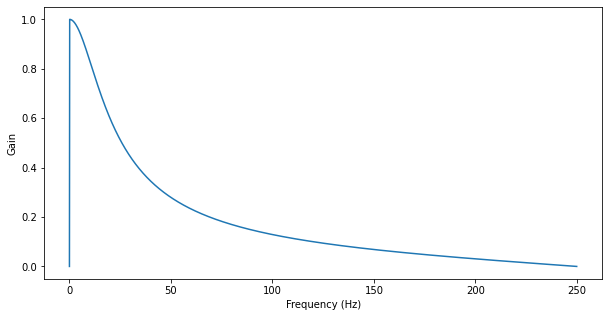

In [ ]:
import cmath
#plotting the frequency response of the filter
b, a = butter(1, [0.001/250, 15/250], btype="band")

w, h = signal.freqz(b, a, worN=2000)
plt.rcParams['figure.figsize'] = [10, 5]
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.plot((500 * 0.5 / np.pi) * w, abs(h), label=1)

## Normalise signal
Normalizamos la señal de [-1,1] a [0,1]


In [ ]:
def normalize(signal):
    '''
    Normalises each sample so as to have a value ranging from 0 to 1
    '''
    signal -= np.mean(signal)
    minimum = np.amin(signal)
    maximum = np.amax(signal)
    
    return (signal - minimum) / ( maximum - minimum)

# Filtering methods

<a name="1"></a>
## Filter 1 (Trial)

In [ ]:
#Define global parameters
filter_lowcut = 0.001
filter_highcut = 15.0
filter_order = 1

def process_data():
    '''
    MAIN method that calls the others to extract all the information regarding the 
    different datasets

    returns inputs (signal), output(class labels), data_tags(qualitataive data from
    the signal)
    '''
    n_samples = 0
    n_wrong = 0
    files = get_files()
    final_files = limpiar_datos(files)
    bar = progressbar.ProgressBar(max_value=len(final_files), \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    inputs = []
    outputs = []
    data_tags = []
    bar.start()

    #Iterate over all the files from the dataset
    for i,file in enumerate(final_files):
      
        #Obtain its feature
        data_dict = get_features(file)

        #Filter for each derivation
        for lead in data_dict["leads"]:
            filtered = bandpass_filter(lead["samples"], lowcut=filter_lowcut, highcut=filter_highcut, signal_freq = data_dict["fs"], filter_order = filter_order)

           
            for s in get_slices(filtered, freq=data_dict['fs']):
                try:
                    normalized = normalize(s)
                except:
                    n_wrong += 1
                    continue
             
                data_tags.append([data_dict['archivo'], data_dict["age"] if data_dict["age"] > 0 else 57 , data_dict["sex"], data_dict["Rx"], data_dict["Hx"], lead["name"]])
                inputs.append(normalized)
                outputs.append(data_dict["output"][0])
                n_samples += 1
        bar.update(i)
    bar.finish()
    print(f'The number of samples that could not be normalised: {n_wrong} samples')
    return inputs, outputs, data_tags

<a name="2"></a>
## Filter 2 (Trial)

In [ ]:
#Métodos para cortar la señal en muestras de 10s

def random_sampling(filtered, freq, resample_freq):

    if freq == 500:
      if len(filtered) > 3000:
        flag = randint(0,(len(filtered)-3000))
        n0 = flag
        n_end = n0+3000
        signal = resample(filtered[n0:n_end],resample_freq)
        return signal 

      elif len(filtered) == 3000 :
     
        signal = resample(filtered,resample_freq)
        return signal
      else:
        background = np.zeros(3000)
        random_n0 = randint(0, 3000-len(filtered))
        counter = 0

        for x in range(random_n0, random_n0+len(filtered)):
          background[x] = filtered[counter]
          counter += 1
        
        signal = resample(background, resample_freq)
        return signal

    elif freq == 1000:
      if len(filtered) > 6000:
        flag = randint(0,(len(filtered)-6000))
        n0 = flag
        n_end = n0+6000
      
        signal = resample(filtered[n0:n_end],resample_freq)
        return signal 

      elif len(filtered) == 6000:
        
        signal = resample(filtered,resample_freq)
        return signal
      else:
        background = np.zeros(6000)
        random_n0 = randint(0, 6000-len(filtered))
        counter = 0

        for x in range(random_n0, random_n0+len(filtered)):
          background[x] = filtered[counter]
          counter += 1
        
        signal = resample(background, resample_freq)
        return signal


In [ ]:
#Define global parameters

filter_lowcut = 0.001
filter_highcut = 15.0
filter_order = 1

def process_data():
    '''
    MAIN method that calls the others to extract all the information regarding the 
    different datasets

    returns inputs (signal), output(class labels), data_tags(qualitataive data from
    the signal)
    '''
    n_samples = 0
    n_wrong = 0
    
    files = get_files()
    final_files = limpiar_datos(files)

    bar = progressbar.ProgressBar(max_value=len(final_files), \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    inputs = []
    outputs = []
    data_tags = []

    bar.start()
    #Iterate over all the files from the dataset
    for i,file in enumerate(final_files):
      
        #Obtain its feature
        data_dict = get_features(file)

        #Filter for each derivation
        for lead in data_dict["leads"]:
            filtered = bandpass_filter(lead["samples"], lowcut=filter_lowcut, highcut=filter_highcut, signal_freq = data_dict["fs"], filter_order = filter_order)

            signal = random_sampling(filtered, freq=data_dict['fs'], resample_freq = 256)
            try:
               normalized = normalize(signal)
            except:
               normalized = np.zeros(len(signal))
              
        
            data_tags.append([data_dict['archivo'], data_dict["age"] if data_dict["age"] > 0 else 57 , data_dict["sex"], data_dict["Rx"], data_dict["Hx"], lead["name"]])
            inputs.append(normalized)
            outputs.append(data_dict["output"][0])
            n_samples += 1
        bar.update(i)
    bar.finish()
    print(f'The number of samples that could not be normalised: {n_wrong} samples')
    return inputs, outputs, data_tags

<a name="3"></a>
## Filter 3 (trial)

In [ ]:
def get_slices_2(signal, freq):
    '''
    Aims to split each signal in several pieces of the same DURATION
    in order to prepare the data for the NN which requires input 
    of the same length
    '''
    signals = []

    if freq == 500:
      while len(signal) > 2999:
        signals.append(resample(signal[:3000],256))
        signal = signal[3001:]

      background = np.zeros(3000)
      random_n0 = randint(0, 3000-len(signal))
      counter = 0

      for x in range(random_n0, random_n0+len(signal)):
        background[x] = signal[counter]
        counter += 1
        
      signals.append(resample(background, 256))

    elif freq == 1000:
      while len(signal) > 5999:
        signals.append(resample(signal[:6000],256))
        signal = signal[6001:]

      background = np.zeros(6000)
      random_n0 = randint(0, 6000-len(signal))
      counter = 0

      for x in range(random_n0, random_n0+len(signal)):
        background[x] = signal[counter]
        counter += 1
        
      signals.append(resample(background, 256))

      
    return signals

In [ ]:
#Define global parameters
filter_lowcut = 0.001
filter_highcut = 15.0
filter_order = 1

def process_data():
    '''
    MAIN method that calls the others to extract all the information regarding the 
    different datasets

    returns inputs (signal), output(class labels), data_tags(qualitataive data from
    the signal)
    '''
    n_samples = 0
    n_wrong = 0
    os.system("rm -rf ./wrong data_tags inputs.csv outputs.csv")
    wrong_dir = "./wrong/"
    os.mkdir(wrong_dir)
    files = get_files()
    final_files = limpiar_datos(files)
    bar = progressbar.ProgressBar(max_value=len(final_files), \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    inputs = []
    outputs = []
    data_tags = []

    #Iterate over all the files from the dataset
    for i,file in enumerate(final_files):
      
        #Obtain its feature
        data_dict = get_features(file)

        #Filter for each derivation
        for lead in data_dict["leads"]:
            filtered = bandpass_filter(lead["samples"], lowcut=filter_lowcut, highcut=filter_highcut, signal_freq = data_dict["fs"], filter_order = filter_order)

           
            for s in get_slices_2(filtered, freq=data_dict['fs']):
                try:
                    normalized = normalize(s)
                except:
                    n_wrong += 1
                    plt.plot(s)
                    plt.savefig(wrong_dir + "W{}.png".format(n_wrong))
                    continue
             
                data_tags.append([data_dict['archivo'], data_dict["age"] if data_dict["age"] > 0 else 57 , data_dict["sex"], data_dict["Rx"], data_dict["Hx"], lead["name"]])
                inputs.append(normalized)
                outputs.append(data_dict["output"][0])
                n_samples += 1
        bar.update(i)
    bar.finish()
    print(n_wrong)
    return inputs, outputs, data_tags

<a name="4"></a>
## Filter DEFINITIVE

In [ ]:
def sampler_randomizer(data_dict):
  '''
  Given the signal it decides the random slice from where to extract the data.
  If the signal is smaller than 3000 or 6000 zero pad random sampling will be 
  used
  '''
  length = (len(data_dict['leads'][0]['samples']))
  frequency = data_dict['fs']

  if frequency == 500:
    if length > 3000:
      n0 = randint(0,(length-3000))
      process = 1

    elif length == 3000 :
      n0 = 0
      process = 2
    else:
      n0 = randint(0, 3000-length)
      process = 3

  if frequency == 1000:
    if length > 6000:
      n0 = randint(0,(length-6000))
      n_end = n0+6000
      process = 4
    elif length == 6000:
      n0 = 0
      process = 5
    else:
      n0 = randint(0, 6000-length)
      process = 6 

  return process, n0

In [ ]:
#Métodos para cortar la señal en muestras de 10s

def random_sampling(filtered, process, n0, resample_freq):
  '''
  Given the output from sampler randomizer, performs the random sampling on
  each lead
  '''

    if process == 1:
      signal = resample(filtered[n0:n0+3000],resample_freq)
      return signal 

    elif process == 2 :
      signal = resample(filtered,resample_freq)
      return signal

    elif process == 3:
        background = np.zeros(3000)
        counter = 0

        for x in range(n0, n0+len(filtered)):
          background[x] = filtered[counter]
          counter += 1
        
        signal = resample(background, resample_freq)
        return signal

    elif process == 4:
      signal = resample(filtered[n0:n0+6000],resample_freq)
      return signal 

    elif process == 5:
      signal = resample(filtered,resample_freq)
      return signal

    else:
      background = np.zeros(6000)
      counter = 0

      for x in range(n0, n0+len(filtered)):
        background[x] = filtered[counter]
        counter += 1 
      signal = resample(background, resample_freq)
      
      return signal

In [ ]:
#Define global parameters

filter_lowcut = 0.001
filter_highcut = 15.0
filter_order = 1

def process_data():
    '''
    MAIN method that calls the others to extract all the information regarding the 
    different datasets

    returns inputs (signal), output(class labels), data_tags(qualitataive data from
    the signal)
    '''
    n_samples = 0
    n_wrong = 0
    
    files = get_files()
    final_files = limpiar_datos(files)

    bar = progressbar.ProgressBar(max_value=len(final_files), \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    inputs = []
    outputs = []
    data_tags = []

    bar.start()
    #Iterate over all the files from the dataset
    for i,file in enumerate(final_files):
      
        #Obtain its feature
        data_dict = get_features(file)
        #We obtain the number of samples per lead for each file and store it
        process, n0 = sampler_randomizer(data_dict)
        #Filter for each derivation
        for lead in data_dict["leads"]:
            filtered = bandpass_filter(lead["samples"], lowcut=filter_lowcut, highcut=filter_highcut, signal_freq = data_dict["fs"], filter_order = filter_order)

            signal = random_sampling(filtered, process, n0, resample_freq = 1024)
            try:
               normalized = normalize(signal)
            except:
               normalized = np.zeros(len(signal))
              
        
            data_tags.append([data_dict['archivo'], data_dict["age"] if data_dict["age"] > 0 else 57 , data_dict["sex"], data_dict["Rx"], data_dict["Hx"], lead["name"]])
            inputs.append(normalized)
            outputs.append(data_dict["output"][0])
            n_samples += 1
        bar.update(i)
    bar.finish()
    print(f'The number of samples that could not be normalised: {n_wrong} samples')
    return inputs, outputs, data_tags

# Extracción de datos

In [ ]:
inputs, outputs, data_tags = process_data()

Initially we have 43027 files...


[                                                                        ] N/A%

After the cleaning we have 37716 files



[========================================================================] 100%


The number of samples that could not be normalised: 0 samples


# Data visualisation

## Single sample plot

In [ ]:
def show_sample(n):
    '''
    Method to analise each sample, displaying the relevent information
    from them
    '''
    Archivo, Age, Sex, Rx, Hx, lead_name= data_tags[n]
    data = np.asarray(inputs[n], dtype = np.float64)
    if Sex == 0:
      Sex = 'Male'
    else:
      Sex = 'Female'
    print('FILE: {}, AGE: {}, SEX: {}'.format(Archivo, Age, Sex))
    plt.style.use('seaborn')
    plt.rcParams['figure.figsize'] = [20, 2]
    plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower  
    plt.plot(data)
    plt.title("Lead: {}".format(lead_name))
    plt.show()
    output = outputs[n]
    for i,o in enumerate(output):
        if o == 1:
            print("Illness: {} ---> {}".format(csv_file['Dx'][i],csv_file['Abbreviation'][i]))

    return None

def zoom(sample, x0, x_final):
    '''
    Take a sample n and plots a slice [x0-x_final]
    '''

    data = np.asarray(inputs[sample], dtype = np.float64)
    data = data[x0:x_final]

    plt.rcParams['figure.figsize'] = [20, 3]
    plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower  
    plt.plot(data)
    
    return None


FILE: HR03966, AGE: 65, SEX: Male


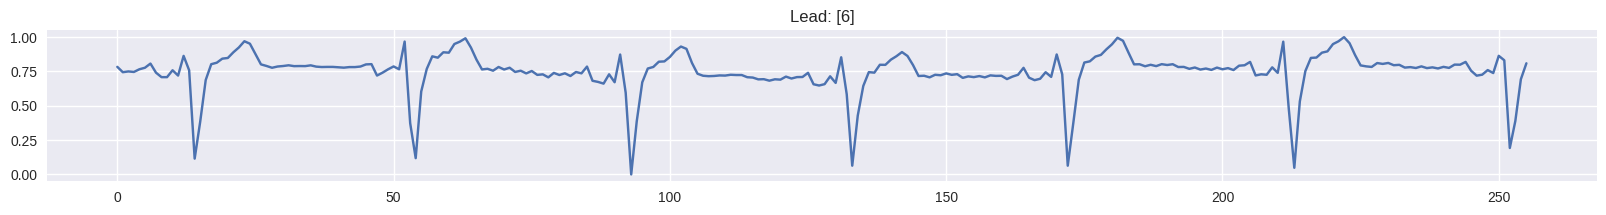

Illness: left axis deviation ---> LAD
Illness: sinus rhythm ---> NSR


In [ ]:
#@title Number fields
sample = 233610 #@param {type:"slider", min:0, max:452592, step:1}
show_sample(sample)

### Zoom into the selected sample

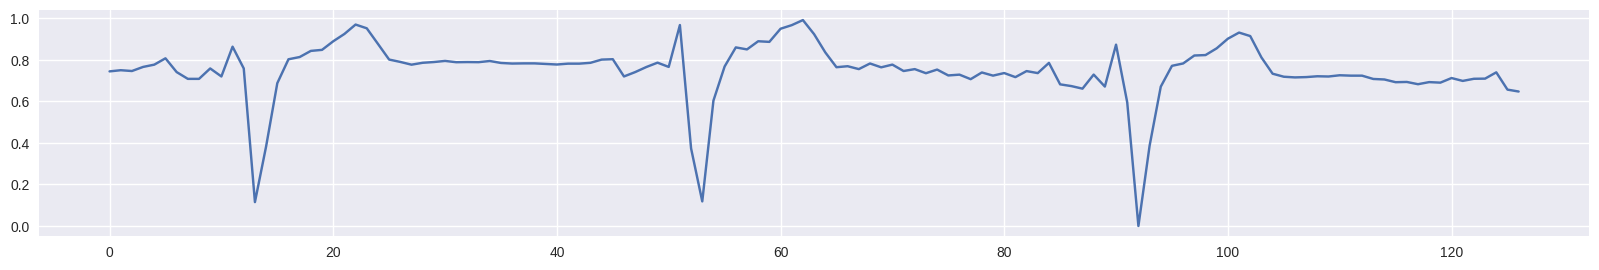

In [ ]:
zoom(sample, 1, 128)

## Plotting multiple leads

In [ ]:
def leads_plot(sample, a0=0, a_final=256):
    lista = []
    disease_list = []
    rest = sample%12
    if rest == 0:
      for x in range(12):
          lista.append('ax'+str(x))
          _, _, _, _, _, lead_name= data_tags[sample+x]
          if lead_name == x:
            lista[x] = np.asarray(inputs[sample+x], dtype = np.float64)
    elif rest > 0:
      sample = sample-rest
      for x in range(12):
        lista.append('ax'+str(x))
        lista[x] = np.asarray(inputs[sample+x], dtype = np.float64)

    output = outputs[sample]

    for i,o in enumerate(output):
        if o == 1:
            disease_list.append(csv_file['Abbreviation'][i])
    var0 = 'Enfermedades presentes en la muestra '+str(sample)+': '
    var = ', '.join(disease_list)
    
    title = var0 + var

    fig, axs = plt.subplots(3,4, figsize=(25,10))
    fig.suptitle(title)
    axs[0, 0].plot(lista[0][a0:a_final])
    axs[0, 0].set_title('I')
    axs[1, 0].plot(lista[1], 'tab:red')
    axs[1, 0].set_title('II')
    axs[2, 0].plot(lista[2][a0:a_final])
    axs[2, 0].set_title('III')
    axs[0, 1].plot(lista[3][a0:a_final])
    axs[0, 1].set_title('aVR')
    axs[1, 1].plot(lista[4][a0:a_final])
    axs[1, 1].set_title('aVL')
    axs[2, 1].plot(lista[5][a0:a_final])
    axs[2, 1].set_title('aVF')
    axs[0, 2].plot(lista[6][a0:a_final])
    axs[0, 2].set_title('V1')
    axs[1, 2].plot(lista[7][a0:a_final])
    axs[1, 2].set_title('V2')
    axs[2, 2].plot(lista[8][a0:a_final])
    axs[2, 2].set_title('V3')
    axs[0, 3].plot(lista[9][a0:a_final])
    axs[0, 3].set_title('V4')
    axs[1, 3].plot(lista[10][a0:a_final])
    axs[1, 3].set_title('V5')
    axs[2, 3].plot(lista[11][a0:a_final])
    axs[2, 3].set_title('V6')

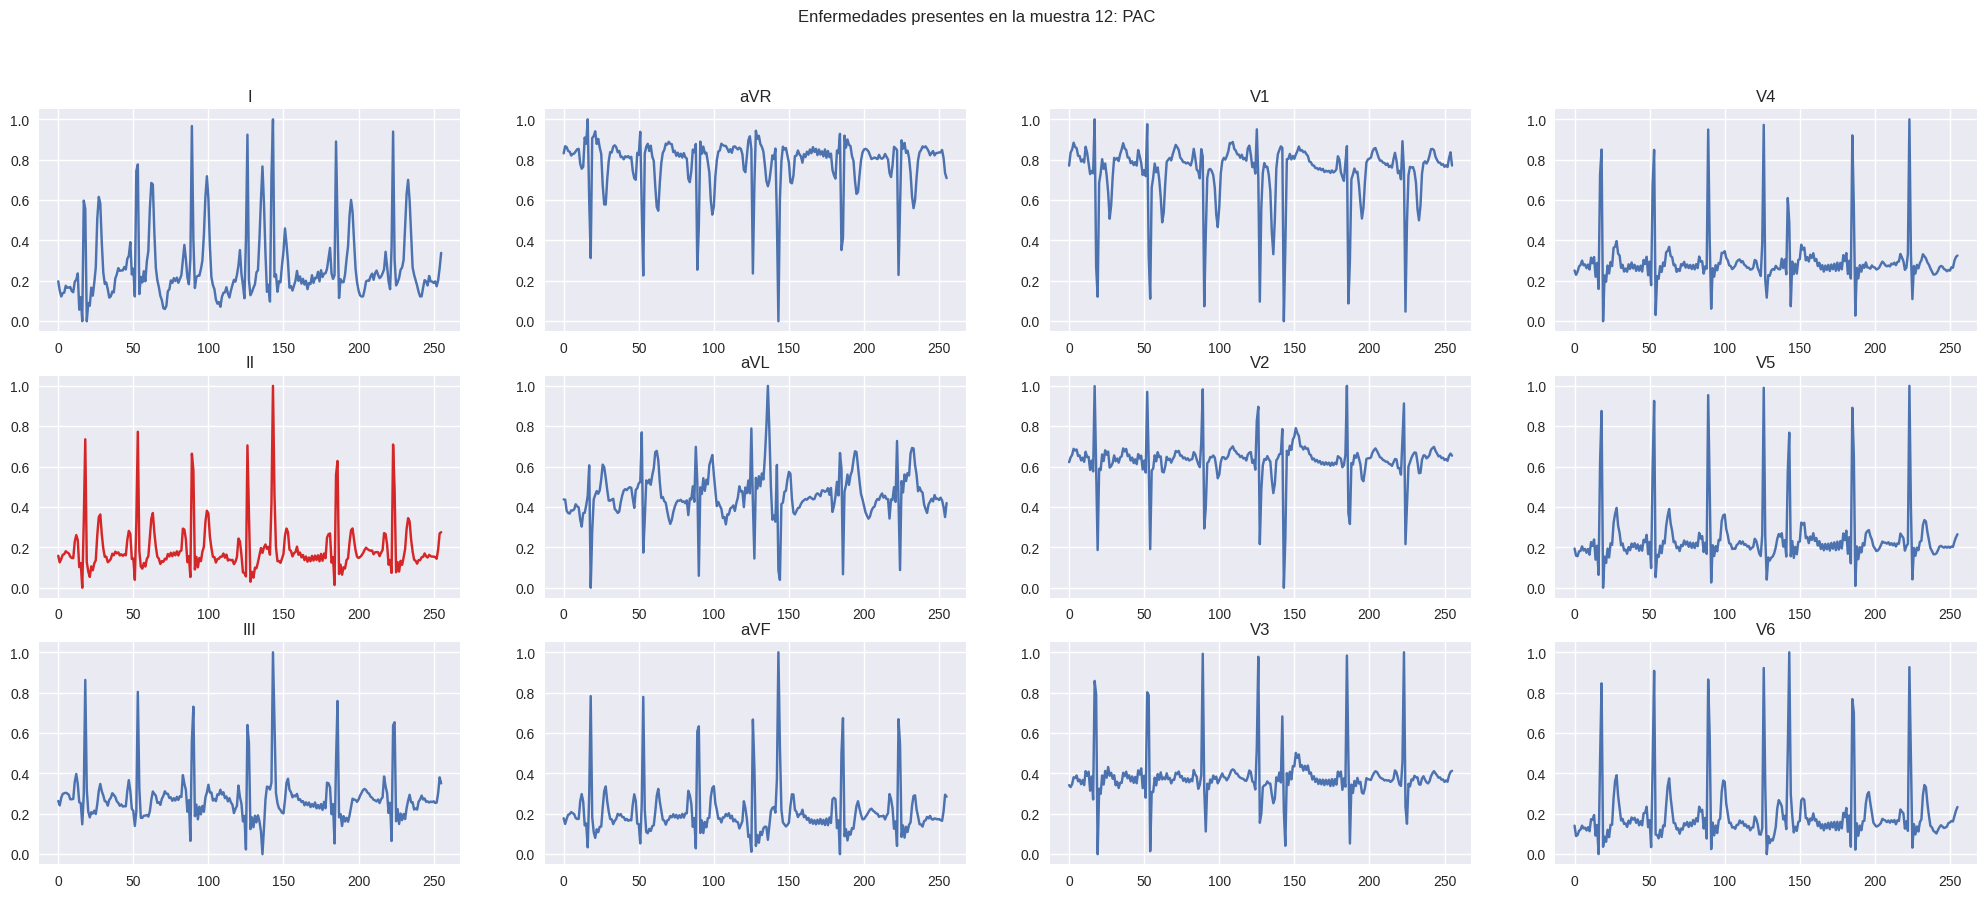

In [ ]:
leads_plot(12)

In [ ]:
csv_file

,Dx,SNOMED CT Code,Abbreviation
0,1st degree av block,270492004,IAVB
1,atrial fibrillation,164889003,AF
2,atrial flutter,164890007,AFL
3,bradycardia,426627000,Brady
4,complete right bundle branch block,713427006,CRBBB
5,incomplete right bundle branch block,713426002,IRBBB
6,left anterior fascicular block,445118002,LAnFB
7,left axis deviation,39732003,LAD
8,left bundle branch block,164909002,LBBB
9,low qrs voltages,251146004,LQRSV


In [ ]:
list_of_disease = []
for x in range(len(outputs)):
  if sum(outputs[x])== 1 and outputs[x][11]==1:
    list_of_disease.append(x)

len(list_of_disease)

3396

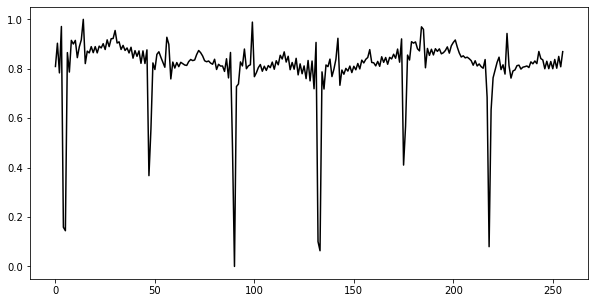

In [ ]:
plt.plot(inputs[list_of_disease[3]], color='k')

## Counting data
Now let's see the characteristics of our new data


In [ ]:
def contar_num_muestras():
  '''
  Method to analise the number of samples per lead,
  this method is useless after filtering as every signal will have been samples
  at 256 
  '''
  total = [] 
  for x in range(len(inputs)):
    length = len(inputs[x].astype(int))
    total.append(length)

  print('The average value of the ECGs is: {} samples'.format(statistics.mean(total)))
  print('The maximum value of the ECGs is: {} samples'.format(max(total)))
  print('The minimum value of the ECGs is: {} samples'.format(min(total)))

  return None 
  contar_num_muestras() 

In [ ]:
def contar_clases():
  '''
  Count the number of classes resulting after the whole preprocessing step
  '''
  aux = np.array(outputs).astype(int)
  suma = np.zeros(aux[1].shape).astype(int)
  for x in aux:
    suma = suma + x
  clases = []
  for x in range(len(suma)):
    aux = (csv_file['Abbreviation'][x] , suma[x])
    clases.append(aux)
    
  return clases

def count_data():
    '''
    Method that checks wether the number of inputs and outputs matches or not
    '''
    print("Inputs: %d" % len(inputs))
    print("Outputs: %d" % len(outputs))




print(contar_clases())
count_data()

[('IAVB', 28728), ('AF', 41676), ('AFL', 3768), ('Brady', 3324), ('CRBBB', 8196), ('IRBBB', 19332), ('LAnFB', 21672), ('LAD', 73032), ('LBBB', 12492), ('LQRSV', 6672), ('NSIVCB', 11952), ('PR', 3588), ('PAC', 20712), ('PVC', 2256), ('LPR', 4080), ('LQT', 18156), ('QAb', 12156), ('RAD', 5124), ('RBBB', 28800), ('SA', 14856), ('SB', 28308), ('NSR', 250152), ('STach', 28692), ('SVPB', 2532), ('TAb', 56076), ('TInv', 13332), ('VPB', 4380)]
Inputs: 452592
Outputs: 452592


## Bar graph of classes distribution

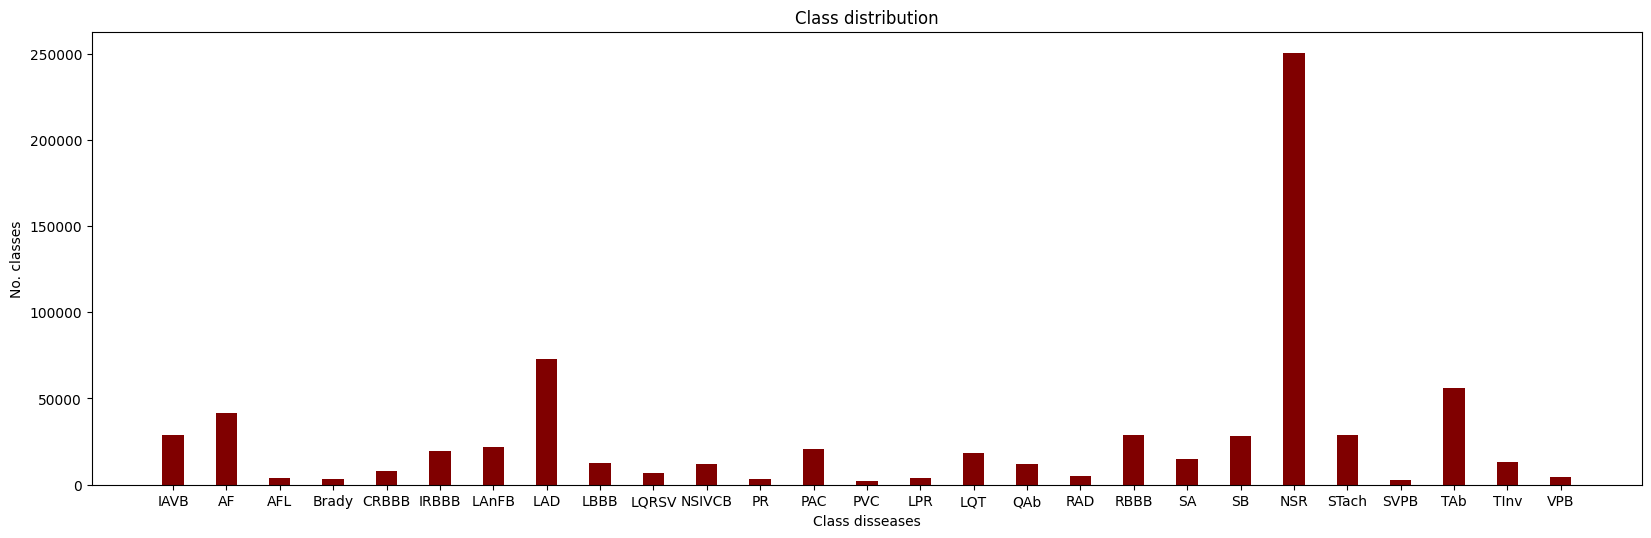

In [ ]:
array=np.zeros(27)
for x in outputs:
   counter = 0
   for y in x:
     if y == 1:
       array[counter]+=1
     counter+=1

plt.rcParams['figure.figsize'] = [20, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower  
plt.bar(csv_file['Abbreviation'], array, color ='maroon',  
         width = 0.4) 

plt.xlabel("Class disseases") 
plt.ylabel("No. classes") 
plt.title("Class distribution") 
plt.show() 

In [ ]:
aux = np.zeros(27)
for x in outputs:
  aux = np.add(aux, x)

aux = np.transpose(np.array(aux).astype(int))

data_plot = pd.DataFrame()
data_plot['Abbreviation'] = csv_file['Abbreviation']
data_plot['Count'] = aux
data_plot = data_plot.sort_values('Count', ascending = False)
representar = data_plot[:10]


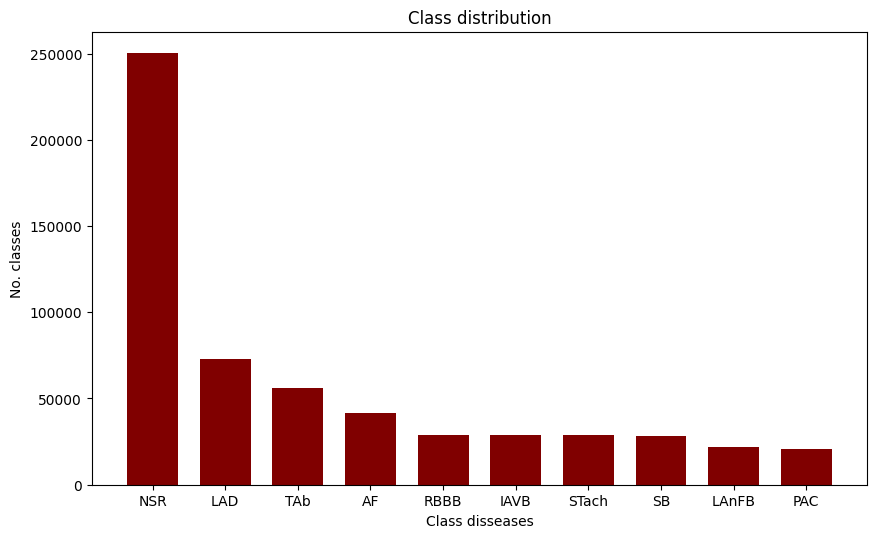

In [ ]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower  
plt.bar(representar['Abbreviation'], representar['Count'], color ='maroon',  
         width = 0.7) 

plt.xlabel("Class disseases") 
plt.ylabel("No. classes") 
plt.title("Class distribution") 
plt.show() 

## Confussion matrix of class labels to show relation between diseases

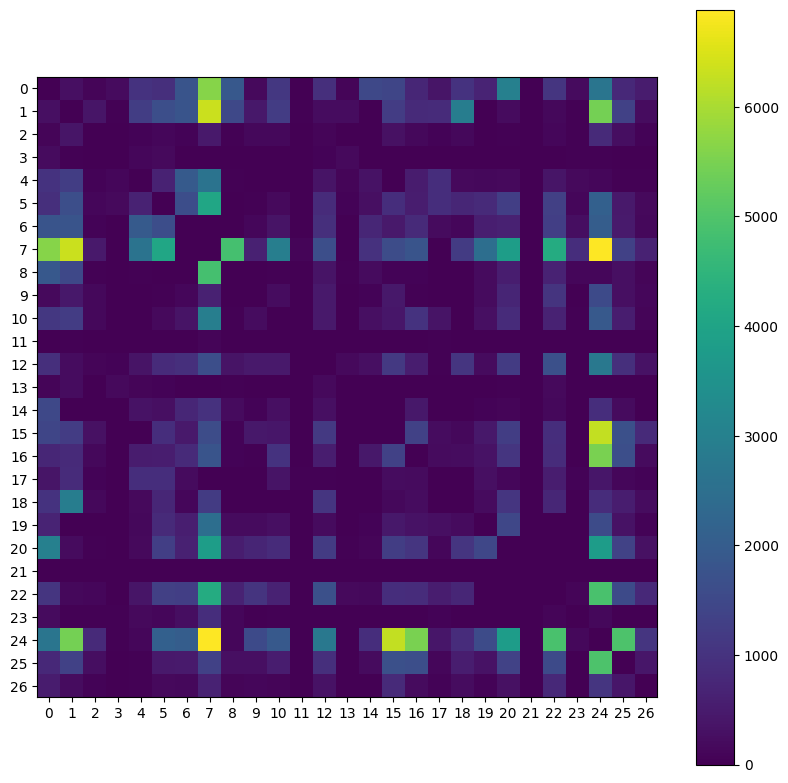

In [ ]:
draft  = np.zeros((len(outputs[0]),len(outputs[0]))).astype(int)

for x in range(len(outputs[0])):
  for y in outputs:
      if y[x] == 1:
          counter = 0
          for w in y:
            if w == 1:
              draft[x][counter] += 1
            counter += 1


np.fill_diagonal(draft, 0)
draft[:,21]=0
draft[21,:]=0
draft[6,7]=0
draft[7,6]=0

fig, ax = plt.subplots(1,1, figsize=(10,10))
img = ax.imshow(draft, cmap='viridis')
fig.colorbar(img, orientation='vertical')

_ = ax.set_yticks(range(27))
_ = ax.set_yticklabels(range(27))

_ = ax.set_xticks(range(27))
_ = ax.set_xticklabels(range(27))

In [ ]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

check_symmetric(draft)

True

# Creacion de un dataframe de Pandas en función de los datos

In [ ]:
def extract_dataframe(data_tags, inputs, outputs):
  '''
  After the data extraction we want to store the information in a Pandas 
  dataframe so that it can be easly extracted in the following parts of the project
  '''
  #Dataframe of data_tags
  df_tags = pd.DataFrame()
  df_tags = df_tags.append(data_tags)
  df_tags = df_tags.rename(columns={0:'file', 1:'age', 2:'sex', 3:'a',4:'b',5:'lead'})
  df_tags = df_tags.drop(columns = {'a', 'b'})
  df_tags.head()
  
  #Dataframe of inputs
  iniciador = {'ecg':[]}
  df_inputs = pd.DataFrame(iniciador)
  total = []
  for input in inputs:
    total.append(input)

  clasificador = {'ecg':total}
  info = pd.DataFrame(clasificador)
  df_inputs = df_inputs.append(info, ignore_index=True)

  #Dataframe of outputs
  iniciador = {'class':[]}
  df_outputs = pd.DataFrame(iniciador)
  total = []
  for output in outputs:
    total.append(output.astype(int))

  clasificador = {'class':total}
  info = pd.DataFrame(clasificador)
  df_outputs = df_outputs.append(info, ignore_index=True)

  #We merge the 3 different dataframes into a global one
  df_final = pd.DataFrame()
  df_final = pd.concat([df_tags, df_inputs, df_outputs], axis=1)
  df_final.head()

  return df_final

In [ ]:
df = extract_dataframe(data_tags, inputs, outputs)
df.head()

,file,age,sex,lead,ecg,class
0,A2593,77,0,[0],"[0.4263167387232811, 0.16846889713223026, 0.25...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,A2593,77,0,[1],"[0.5518418990287832, 0.6727970444427817, 0.665...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,A2593,77,0,[2],"[0.6188412096724579, 0.9505915571906978, 0.862...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
3,A2593,77,0,[3],"[0.4325680568725911, 0.5640781334961479, 0.505...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,A2593,77,0,[4],"[0.3700369934842348, 0.05845158445340801, 0.14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


In [ ]:
df.to_pickle('/content/drive/MyDrive/TFM_DATA/m2_1024.pkl')

# ECG plots for the thesis

In [ ]:
files = get_files()

In [ ]:
data_dict = get_features(files[0])
ecg = data_dict['leads'][1]['samples']
plt.plot(ecg, 'tab:red')
plt.xlabel('RAW ECG')
plt.ylabel('Amplitude')

In [ ]:
 ecg_filtrado = data_dict['leads'][1]['samples']
 filtered = bandpass_filter(ecg_filtrado, lowcut=1, highcut=10, signal_freq = data_dict["fs"], filter_order = filter_order)
 plt.plot(filtered)
 plt.axvline(3000, color='g', linestyle='--')
 plt.axvline(6000, color='g', linestyle='--')
 plt.axvline(len(filtered+1),color='g', linestyle='--')
 plt.plot(range(6001,len(filtered)),filtered[6001:len(filtered)],'tab:grey')
 plt.xlabel('Filtered ECG')
 plt.ylabel('Amplitude')

Text(0.5, 1.0, 'Subsampled 2nd slice')

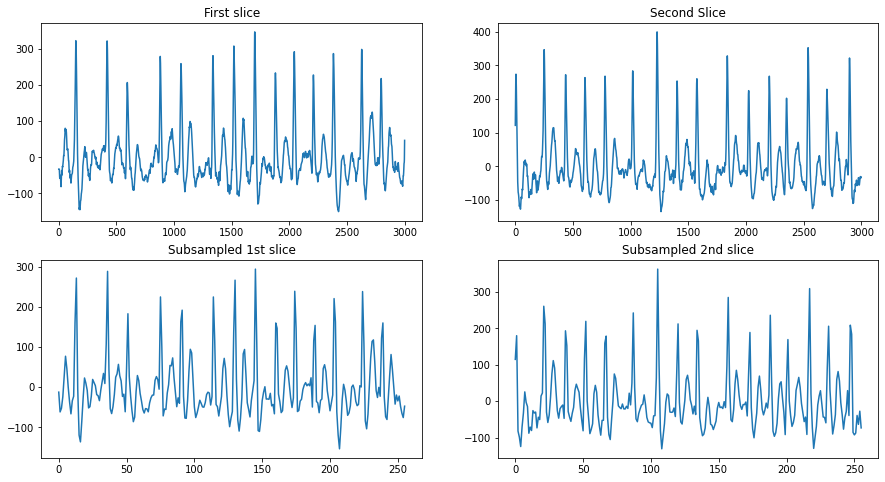

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
axs[0,0].plot(filtered[0:2999])
axs[0,0].set_title('First slice')
axs[1,0].plot(resample(filtered[0:2999],256))
axs[1,0].set_title('Subsampled 1st slice')
axs[0,1].plot(filtered[3000:5999])
axs[0,1].set_title('Second Slice')
axs[1,1].plot(resample(filtered[3000:5999],256))
axs[1,1].set_title('Subsampled 2nd slice')

Text(0, 0.5, 'Amplitude')

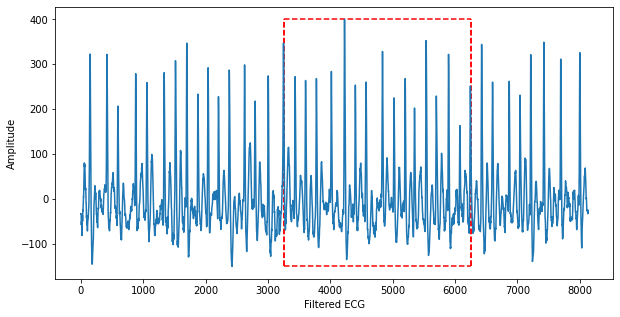

In [ ]:
plt.vlines(x=[3254, 3254+3000], ymin=-150, ymax=400, colors='red', ls='--')
plt.plot(filtered)
plt.vlines(x=[3254, 3254+3000], ymin=-150, ymax=400, colors='red', ls='--')
plt.hlines(y=[-150,400], xmin=3254 ,xmax=3254+3000 , color='red', ls='--')
plt.xlabel('Filtered ECG')
plt.ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

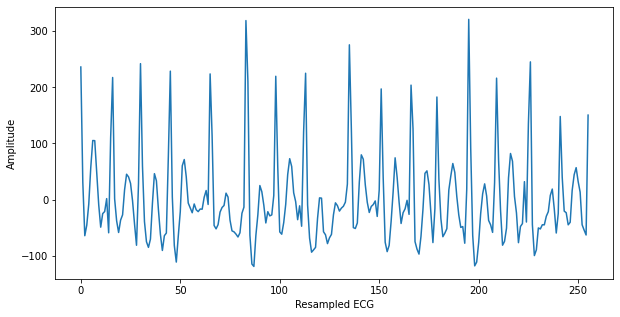

In [ ]:
plt.plot(resample(filtered[3254:3254+3000],256))
plt.xlabel('Resampled ECG')
plt.ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

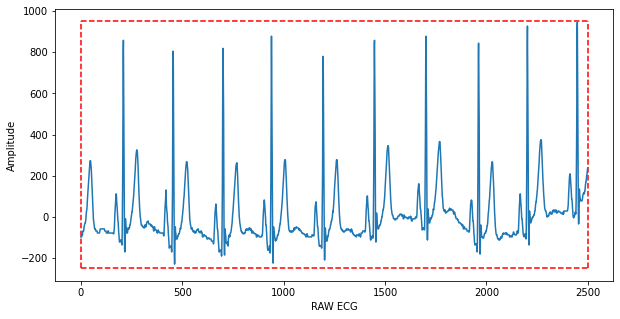

In [ ]:
data_dict2 = get_features(files[10445])
ecg = data_dict2['leads'][1]['samples']
plt.plot(ecg)
plt.vlines(x=[0, 2501], ymin=-250, ymax=950, colors='red', ls='--')
plt.hlines(y=[-250,950], xmin=0 ,xmax=2500 , color='red', ls='--')
plt.xlabel('RAW ECG')
plt.ylabel('Amplitude')

Text(0.5, 1.0, 'Random indent resampled')

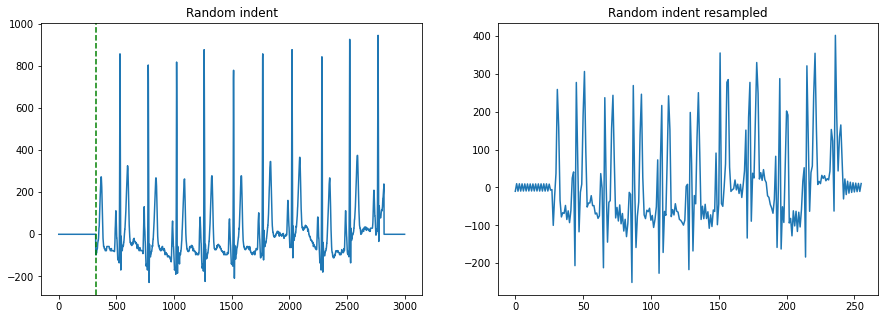

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].plot(np.insert(np.zeros(3000), 321, ecg)[0:3000])
axs[0].set_title('Random indent')
axs[0].axvline(321, color='g', linestyle='--')

axs[1].plot((resample(np.insert(np.zeros(3000), 321, ecg)[0:3000],256)))
axs[1].set_title('Random indent resampled')

# Extracting ECG features and Grid Test

In [ ]:
files = get_files()

In [ ]:
data_dict = get_features(files[0])
señal = data_dict['leads'][1]['samples']

In [ ]:
import math
def roundup(x):
   return int(math.ceil(x / 100.0)) * 100

def rounddown(x):
   return int(math.floor(x / 100.0)) * 100


ecg_duration = (6*len(señal))/3000
ecg_duration

10.0

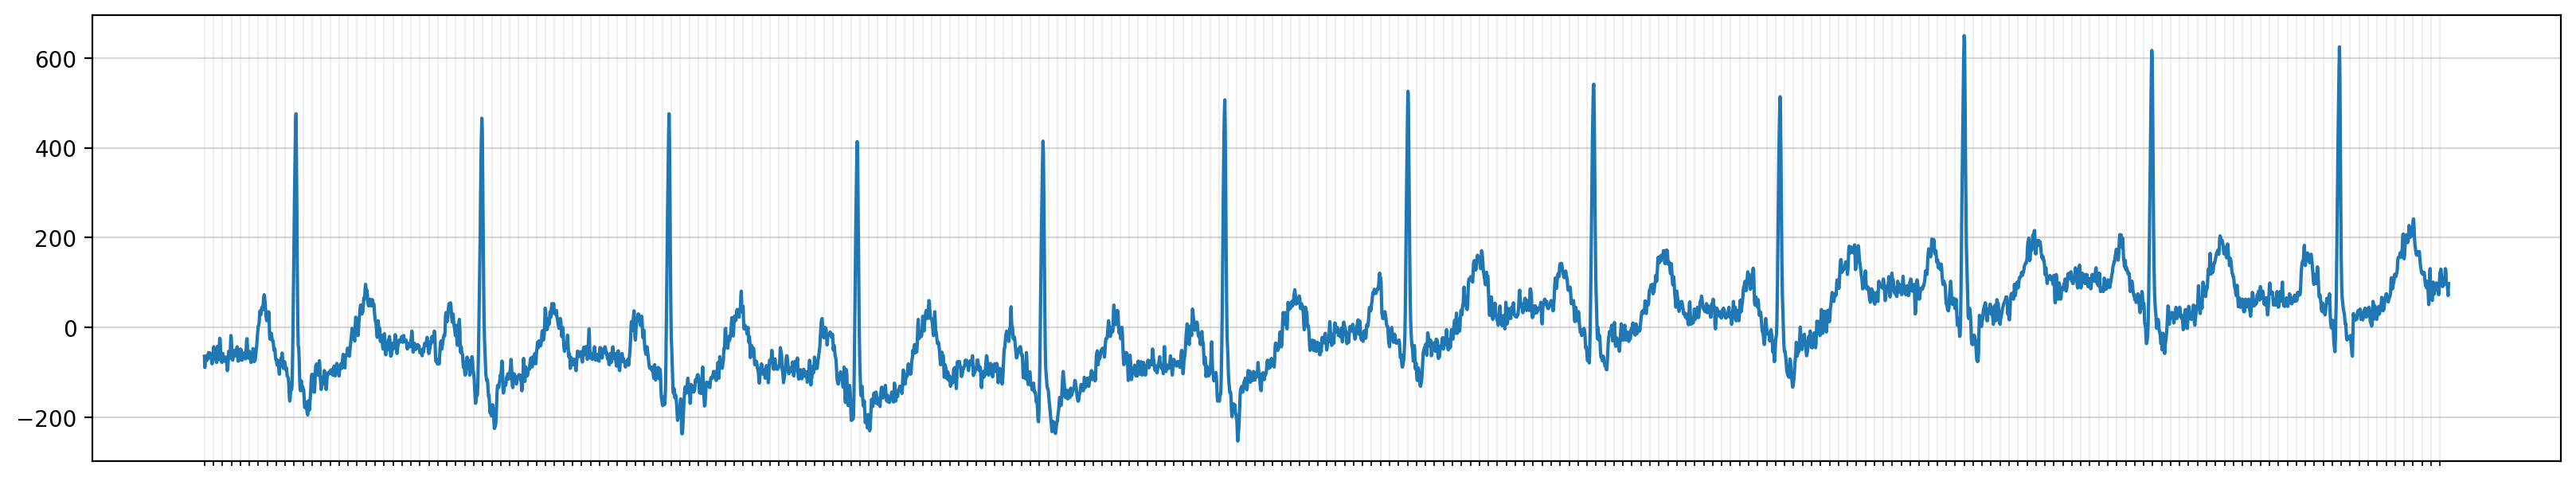

In [ ]:
fig = plt.figure(figsize=(20, 6), dpi=200)
ax = fig.add_subplot(1, 1, 1)
ax.plot(señal)
# Major ticks every 20, minor ticks every 5
major_ticks_x = np.arange(0, len(señal), 0.2*len(señal)/ecg_duration)
minor_ticks_x = np.arange(0, len(señal),  (0.2*len(señal)/ecg_duration)/5)

#major_ticks_y = np.arange(rounddown(min(señal)), roundup(max(señal)),100)
#minor_ticks_y = np.arange(rounddown(min(señal)), roundup(max(señal)), 100/5)

#ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)

#ax.set_yticks(major_ticks_y)
#ax.set_yticks(minor_ticks_y, minor=True)

# And a corresponding grid
ax.grid(which='both', axis='x')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
ax.get_xaxis().set_ticks([])
ax.set_aspect('equal')
plt.show()

# Peaks detection

In [ ]:
_, rpeaks = nk.ecg_peaks(señal, sampling_rate=500)

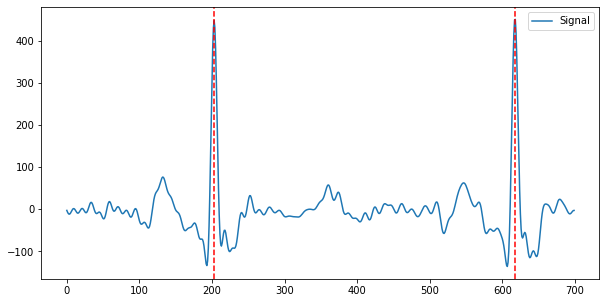

In [ ]:
# Visualize R-peaks in ECG signal
plot = nk.events_plot(rpeaks['ECG_R_Peaks'][0:2], señal[0:700])

In [ ]:
_, waves_peak = nk.ecg_delineate(señal, rpeaks, sampling_rate=500)

In [ ]:
waves_peak.keys()

dict_keys(['ECG_T_Peaks', 'ECG_T_Onsets', 'ECG_T_Offsets', 'ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 'ECG_R_Onsets', 'ECG_R_Offsets'])

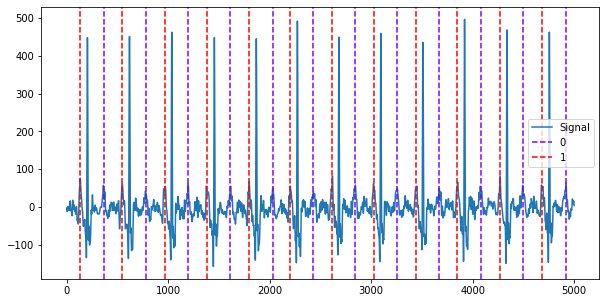

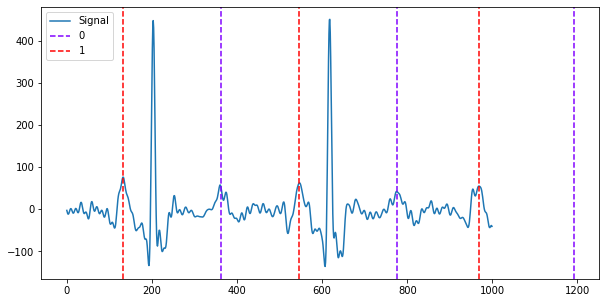

In [ ]:
# Visualize the T-peaks, P-peaks, Q-peaks and S-peaks
plot = nk.events_plot([waves_peak['ECG_T_Peaks'],
                       waves_peak['ECG_P_Peaks'],], señal)

# Zooming into the first 3 R-peaks, with focus on T_peaks, P-peaks, Q-peaks and S-peaks
plot = nk.events_plot([waves_peak['ECG_T_Peaks'][:3],
                       waves_peak['ECG_P_Peaks'][:3],], señal[0:1000])

# Metodos finales

In [ ]:
from statistics import mean
def get_averaged_heartbeat(signal, frequency):
  out = ecg.ecg(signal=signal, sampling_rate=frequency, show=False)
  
  return round(mean(out['heart_rate']),2)

get_averaged_heartbeat(señal, 500)

83.08

In [ ]:
def y_range_ecg(data_dict):
  '''
  This method extracts the total range of the ECG strips
  E.g. range(I+V1)+range(II+V2)+range(III+V3)
  '''
  range_list=[]
  for x in range(6):
    y = x+6
    signal = data_dict['leads'][x]['samples']
    signal2 = data_dict['leads'][y]['samples']
    strip = np.concatenate((signal,signal2))
    rango = max(strip) - min(strip)

    range_list.append(rango)

  return int(sum(range_list)), range_list


In [ ]:
from matplotlib.figure import Figure

def create_grid(ecg_duration, freq, total_range):
    fig = Figure(figsize=(10,10), dpi=200)
    ax = fig.add_subplot(1, 1, 1)
    
    
    ax.set_xticks(np.arange(-300, (3000*2)+300, freq*0.2))
    ax.set_yticks(np.arange(-1000, total_range+1000, freq*0.2))

    # And a corresponding grid
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.grid(which='both', axis='both')
    # Or if you want different settings for the grids:
    ax.set_aspect("equal")

    return fig, ax

In [ ]:
def get_ecg_duration(signal, freq):
    ecg_duration = len(signal)/freq
    return ecg_duration

In [ ]:
def filter_single_ECG(data_dict):
  process, n0 = sampler_randomizer(data_dict)
  for x in range(12):
    
    print(process, n0)
    signal = ecg.ecg(signal=data_dict['leads'][x]['samples'], sampling_rate=data_dict['fs'], show=False)['filtered']
    filtered = bandpass_filter(signal, 0.001, 15, data_dict['fs'],1)
    filtered = random_sampling(filtered, process, n0, 3000)
    print(len(filtered))
    data_dict['leads'][x]['samples'] = filtered

  return data_dict

In [ ]:
def oneshot_plot_12ECG(data_dict):

  leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
  total_range, range_list = y_range_ecg(data_dict)
  signal = data_dict['leads'][0]['samples']
  freq = data_dict['fs']
  duration = get_ecg_duration(signal, freq)
  fig, ax = create_grid(duration, freq, total_range)
  counter = range_list[0]
  lead_delimiter = ax.axvline(len(signal), color='g', linestyle='--')

  for x in range(6):
    
    y = x+6
    signal = ecg.ecg(signal=data_dict['leads'][x]['samples'], sampling_rate=freq, show=False)['filtered']
    signal2 = ecg.ecg(signal=data_dict['leads'][y]['samples'], sampling_rate=freq, show=False)['filtered']
    strip = np.concatenate((signal,signal2))

    if x == 0:
      displacement = int(total_range) - (counter)
    elif x == 5:
      displacement = int(total_range) - (counter)
    else:
      displacement = int(total_range) - (counter)

    ax.text(0,displacement+200,leads[x])
    ax.text(duration*freq, displacement+200, leads[y])
    
    
    counter += range_list[x]
    x_axis = range(len(strip))
    y_axis = np.add(strip,displacement)
    
    
    lead_delimiter
    ax.plot(x_axis,y_axis)

    fig.savefig('imagen.png')
  
  return 

In [ ]:
oneshot_plot_12ECG(filter_single_ECG(data_dict))

1 12626
3000
1 12626
3000
1 12626
3000
1 12626
3000
1 12626
3000
1 12626
3000
1 12626
3000
1 12626
3000
1 12626
3000
1 12626
3000
1 12626
3000
1 12626
3000


In [ ]:
files =  get_files()
data_dict = get_features(files[0])

# ECG feature extraction

In [ ]:
files =  get_files()
data_dict = get_features(files[0])

In [ ]:
from statistics import mean

def get_averaged_heartbeat(signal, frequency):
  out = ecg.ecg(signal=signal, sampling_rate=frequency, show=False)
  
  return round(mean(out['heart_rate']),2)

def get_R_peaks(signal, frequency):
  _, rpeaks = nk.ecg_peaks(signal, frequency)
  return rpeaks

def get_other_peaks(signal, frequency):
  rpeaks = get_R_peaks(signal, frequency)
  _, waves_peak = nk.ecg_delineate(signal, rpeaks, sampling_rate=500)
  return waves_peak['ECG_T_Peaks'], waves_peak['ECG_P_Peaks']

def distance_between_same_peaks(list_of_samples, freq):
  time = np.multiply(np.divide(np.array(list_of_samples),freq),1000)

  shifted = np.roll(time, 1)
  result = np.subtract(time, shifted)
  result = np.delete(result, 0)
  mean_RR = np.mean(result)

  return result, mean_RR

def transform_to_time(signal, freq):
  time_list = np.multiply(np.divide(np.array(signal),freq),1000)
  return time_list


def dist_betweenWaves(wave1, wave2):
  if len(wave1) != len(wave2):
    print(len(wave1),len(wave2))
    print('The number of peaks must match')

  wave1,  wave2 = np.array(wave1), np.array(wave2)
  result = np.subtract(wave2, wave1)
  mean_W1_W2 = np.mean(result)

  return result, mean_W1_W2


def get_ECG_features(data_dict):

  # We extract the signal that we desire
  signal = data_dict['leads'][1]['samples']
  freq = data_dict['fs']
  signal = ecg.ecg(signal=signal, sampling_rate=data_dict['fs'], show=False)['filtered']

  # Extract the information of the R peaks
  R_peaks = get_R_peaks(signal, freq)['ECG_R_Peaks']
  
  t_R_peaks, mean_RR = distance_between_same_peaks(R_peaks, freq)

  # Extract the information of the rest of the peaks
  T_peaks, P_peaks = get_other_peaks(signal, freq)
  # T wave
  t_T_peaks, mean_TT = distance_between_same_peaks(T_peaks, freq)
  # P wave
  t_P_peaks, mean_PP = distance_between_same_peaks(P_peaks, freq)

  # PR interval
  t_PR_interval, mean_PR = dist_betweenWaves(P_peaks, R_peaks)

  #RT interval
  t_RT_interval, mean_RT = dist_betweenWaves(R_peaks, T_peaks)

  # Upload the data into a dictionary
  ecg_features = {}

  ecg_features['average_RR_distance'] = np.round(mean_RR,0).astype(int)
  ecg_features['RR_distance'] = t_R_peaks.astype(int)

  ecg_features['average_TT_distance'] = np.round(mean_TT,0).astype(int)
  ecg_features['TT_distance'] = t_T_peaks.astype(int)

  ecg_features['average_PP_distance'] = np.round(mean_PP,0).astype(int)
  ecg_features['PP_distance'] = t_P_peaks.astype(int)

  ecg_features['average_PR_distance'] = np.round(mean_PR,0).astype(int)
  ecg_features['PR_distance'] = t_PR_interval.astype(int)

  ecg_features['average_RT_distance'] = np.round(mean_RT,0).astype(int)
  ecg_features['RT_distance'] = t_RT_interval.astype(int)

  ecg_features['average_bpm'] = np.round(get_averaged_heartbeat(signal, freq),0).astype(int)



  return ecg_features


aux = get_ECG_features(data_dict)
aux


{'PP_distance': array([ 956,  866,  624,  846,  758, 1176,  700,  924,  450, 1024,  490]),
 'PR_distance': array([ 87, 113,  76, 151, 193,  93,  84, 153,  70, 169,  83, 115]),
 'RR_distance': array([1008,  792,  774,  930,  558, 1158,  838,  758,  648,  852,  554]),
 'RT_distance': array([ 48, 139,  61,  50,  60,  56, 149,  53,  61,  74,  49, 173]),
 'TT_distance': array([1190,  636,  752,  950,  550, 1344,  646,  774,  674,  802,  802]),
 'average_PP_distance': 801,
 'average_PR_distance': 116,
 'average_RR_distance': 806,
 'average_RT_distance': 81,
 'average_TT_distance': 829,
 'average_bpm': 78}